In [1]:
import pandas as pd
import spacy

### Import reviews Pennsylvania, pos, neg, neutral

In [ ]:
reviews = pd.read_csv('data/review_pa_sentiment.csv')

In [ ]:
reviews[['sentiment_label', 'sentiment_score']] = reviews['result'].str.split(', ', expand=True)
reviews[['delete', 'sentiment_label']] = reviews['sentiment_label'].str.split(' ', expand=True)

In [ ]:
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace('LABEL_2', 'Positive')
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace('LABEL_1', 'Neutral')
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace('LABEL_0', 'Negative')
reviews['sentiment_label'] = reviews['sentiment_label'].str.replace("'", "")

In [ ]:
reviews.drop(columns=['delete', 'result', 'sentiment_score'], inplace=True, errors='ignore')

In [ ]:
neg_reviews = reviews[reviews['sentiment_label'] == 'Negative']

In [ ]:
neg_reviews

In [ ]:
reviews_list = []

for review in neg_reviews['text'][:1500]:
    reviews_list.append(review)

reviews_text = ', '.join(reviews_list)

In [ ]:
reviews_text = reviews_text.lower()

### Import negative reviews 3.5 stars, Pennsylvania

In [2]:
reviews = pd.read_csv('data/biz_review_ 3-5.csv')

In [3]:
reviews_text = reviews['text'].str.lower()

### Prepare food labels to train entity ruler. Train entity ruler

In [11]:
# Training the entity rule to recognize food

food_df = pd.read_csv('data/food_labels.csv')

In [12]:
food_labels = food_df[food_df['description'].str.contains('[a-zA-Z]') == True]['description']

In [13]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [14]:
food_labels = food_labels.str.lower()

In [15]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [16]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [17]:
# If label has no plural, create singular form. If label has no singular, create plural 

import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

In [18]:
food_labels_inflected = pd.Series(inflected_labels)

In [19]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [20]:
food_labels.drop_duplicates(inplace=True)

In [22]:
food_labels[food_labels.str.contains('bar', regex=True)]

2645        italian barley
3702        barbecue spice
5431               bar bar
5547            fudge bars
7690         sweet bar-b-q
               ...        
15881          chunky bars
16540           limon bars
16663         hazelnut bar
16778    blueberry golbars
17113             paleobar
Length: 538, dtype: object

In [23]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [25]:
len(patterns)

30704

In [ ]:
ruler.to_disk('data/food_patterns.jsonl')

In [23]:
nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe("entity_ruler", before='ner')

ruler.from_disk('data/food_patterns.jsonl')

### Use matcher to analyse text

In [92]:
# Use this one for all of the reviews

from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'ENT_TYPE': 'FOOD'},
        {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
        {'DEP': 'neg', 'OP': '?'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ'}
    ]
]

matcher.add('FOOD_IS', pattern, greedy='LONGEST')

matches_temp = []
matches = []

for text in reviews_text:
    doc=nlp(text)
    matches_temp = matcher(doc)
    if matches_temp != []:
        for match in matches_temp:
            matches.append(doc[match[1]:match[2]].text)

In [94]:
len(matches)

35867

In [95]:
matches_series = pd.Series(matches)

matches_series = matches_series.str.replace('n\'t', 'not')

In [131]:
matches_series.to_csv('data/matches_food_labels.csv', index=True, mode='w', header=True)

In [102]:
import spacy
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'DEP': 'neg', 'OP': '?'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ'}
    ]
]
matcher.add('FOOD_ADJ_ONLY', pattern, greedy='LONGEST')

matches_temp = []
matches = []

for text in matches_series:
    doc=nlp(text)
    matches_temp = matcher(doc)
    if matches_temp != []:
        for match in matches_temp:
            matches.append(doc[match[1]:match[2]].text)

In [103]:
word_frequencies = {}

for item in matches:
    if item not in word_frequencies:
        word_frequencies[item] = 1
    else:
        word_frequencies[item] += 1

In [104]:
word_frequencies

{'more': 54,
 'fine': 523,
 'now equal': 1,
 'no better': 29,
 'not great': 77,
 'ok': 1361,
 'not authentic': 21,
 'very comparable': 1,
 'tangy': 3,
 'horrible': 415,
 'bad': 302,
 'consistently good': 7,
 'cold': 961,
 'hot': 105,
 'cheap': 72,
 'all right': 11,
 'huge': 54,
 'very good': 386,
 'just bad': 18,
 'pretty bad': 45,
 'hard': 252,
 'disappointing': 104,
 'pretty good': 487,
 'good': 3477,
 'topnotch': 1,
 'fake': 11,
 'completely flavorless': 15,
 'extremely firm': 1,
 'grey': 20,
 'fresh': 176,
 'really overcooked': 1,
 'absolutely sub': 1,
 'extremely dangerous': 1,
 'weak': 75,
 'soggy': 281,
 'dry': 782,
 'not right': 3,
 'still good': 45,
 'too freakin': 1,
 'too salty': 59,
 'not impressive': 11,
 'great': 836,
 'tough': 133,
 'lackluster': 42,
 'bizarre': 7,
 'so cheap': 3,
 'rather disappointing': 2,
 'lukewarm': 111,
 'just average': 48,
 'completely mediocre': 3,
 'tacky': 3,
 'cool': 27,
 'just weird': 9,
 'mediocre': 744,
 'still great': 7,
 'inexcusable': 3,

In [89]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

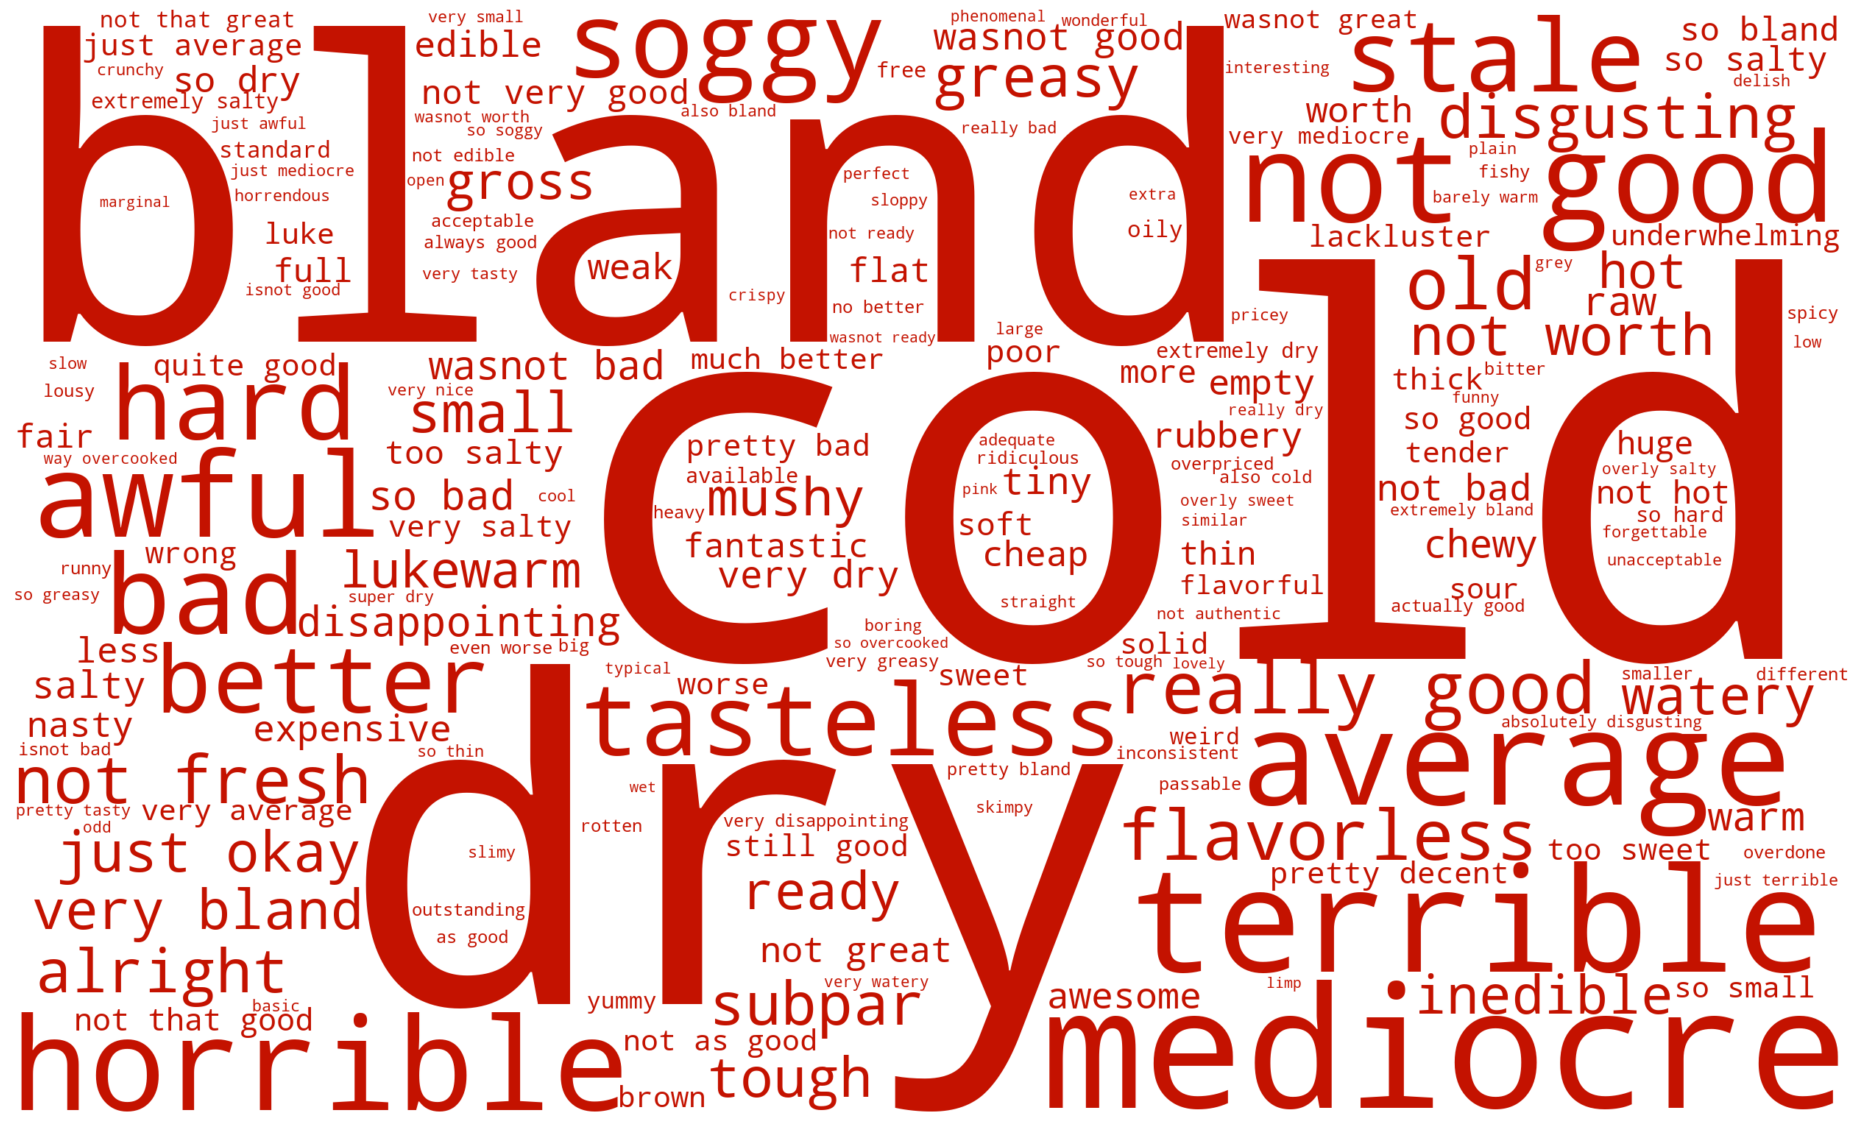

In [125]:
plt.figure( figsize=(11.87*2, 7.42*2))

wordcloud = WordCloud(
    width=2500, height=1500, prefer_horizontal=1.5, color_func=lambda *args, **kwargs: (196,18,0), background_color='white'
)

stopwords = {
    'good',
    'great',
    'decent',
    'pretty good',
    'very good',
    'ok',
    'okay',
    'tasty',
    'fine',
    'nice',
    'delicious',
    'amazing',
    'isnot',
    'fresh', 
    'excellent'    
}

filtered_word_frequencies = {word: freq for word, freq in word_frequencies.items() if word not in stopwords}

wordcloud.fit_words(filtered_word_frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
labels_df = pd.DataFrame({'matched_labels': list_matches})

In [ ]:
labels_df.value_counts().head(20)

In [ ]:
fig, ax = plt.subplots(figsize=(40, 5))

sns.barplot(x=list(filtered_word_frequencies.keys()), y=list(filtered_word_frequencies.values()));

In [ ]:
import spacy
from spacy.matcher import Matcher

# nlp = spacy.load('en_core_web_lg')  # !!!Do not load again, because will reset the modified entity ruler from above

matcher = Matcher(nlp.vocab)

pattern = [
    [
        {'ENT_TYPE': 'FOOD'},
        {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
        # {'DEP': 'neg', 'OP': '?'},
        # {'POS': 'ADV', 'OP': '?'},
        # {'POS': 'ADJ'},
        {'TEXT': 'good'},
        {'TEXT': 'but'}

    ]#,
    # [
    #     # {'POS': 'ADJ'},
    #     {'ENT_TYPE': 'FOOD'}
    # ]  
]
matcher.add('FOOD_IS', pattern, greedy='LONGEST')

# doc=nlp(reviews_text)
doc=nlp(reviews_text)
matches_t = matcher(doc)

# Create list of top ten adjectives that were used to describe the food
# Show as a word cloud

In [ ]:
print(len(matches_t))

for match in matches_t:
    print(match, doc[match[1]-10:match[2]+10])

In [113]:
sum = 1423 + 11957 + 4428 + 35867

sum

53675

In [ ]:
df_categories = pd.DataFrame({})